### Importing necessary packages and modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras import backend as K
from keras import layers
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.optimizers import Adam

import tensorflow as tf

Using TensorFlow backend.


### Defining KL-Divergence and Sampling layers

In [2]:
class KLDivergenceLayer(layers.Layer):
    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):
        mu, log_var = inputs
        kl_loss = K.exp(log_var) + K.square(mu) - 1 - log_var
        kl_loss = 0.5*kl_loss
        kl_loss = K.mean(kl_loss)
        self.add_loss(kl_loss, inputs=inputs)
        
        return inputs

class SamplingLayer(layers.Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(SamplingLayer, self).__init__(**kwargs)

    def call(self, inputs):
        z_mean, z_log_var, eps = inputs
        return z_mean + K.exp(0.5 * z_log_var) * eps

### Defining the encoder

In [3]:
latent_dim = 10

# Encoder
encoder_inputs = layers.Input(shape=(28, 28, 1), name='encoder_input')
epsilon = layers.Input(tensor=K.random_normal(stddev=1.0, shape=(K.shape(encoder_inputs)[0], latent_dim)), name='epsilon')

x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(16, activation='relu')(x)

z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z_mean, z_log_var = KLDivergenceLayer(name='KLD')([z_mean, z_log_var])
z_sigma = layers.Lambda(lambda t: K.exp(0.5*t))(z_log_var)
z_eps = layers.Multiply()([z_sigma, epsilon])
z = layers.Add()([z_mean, z_eps])

encoder = Model([encoder_inputs, epsilon], [z_mean, z_sigma, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 3136)         0           conv2d_2[0][0]                   
____________________________________________________________________________________________

### Defining the decoder

In [4]:
# Decoder
decoder_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(16, activation='relu')(decoder_inputs)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(7 * 7 * 64, activation="relu")(x)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = Model(decoder_inputs, decoder_outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                176       
_________________________________________________________________
dense_5 (Dense)              (None, 256)               4352      
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              263168    
_________________________________________________________________
dense_7 (Dense)              (None, 3136)              3214400   
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        3692

### Defining Variational Auto-encoder

In [5]:
# VAE
vae_inputs_x = encoder_inputs
vae_epsilon = epsilon

_, _, z_sampled = encoder([vae_inputs_x, vae_epsilon])
vae_outputs = decoder(z_sampled)
vae = Model([vae_inputs_x, epsilon], vae_outputs, name='VAE')
vae.summary()

Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
epsilon (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 10), (None,  3497956     encoder_input[0][0]              
                                                                 epsilon[0][0]                    
__________________________________________________________________________________________________
decoder (Model)                 (None, 28, 28, 1)    3537777     encoder[1][2]                  

###  Loading the MNIST dataset

In [6]:
(x_train, _), (x_test, _) = mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255
print(mnist_digits.shape)

(70000, 28, 28, 1)


### Defining VAE loss function

In [7]:
def vae_loss(x_true, x_pred):
    const = K.cast(K.shape(x_true)[1], 'float32')**2
    return K.mean(const*K.binary_crossentropy(x_true, x_pred))

### Train the autoencoder

In [8]:
vae.compile(optimizer=Adam(), loss=vae_loss)
vae.fit(mnist_digits, mnist_digits, shuffle=True, batch_size=128, epochs=10)

Epoch 1/10
70000/70000 [==============================] - 16s 235us/step - loss: 164.2814
Epoch 2/10
70000/70000 [==============================] - 14s 200us/step - loss: 112.0271
Epoch 3/10
70000/70000 [==============================] - 14s 201us/step - loss: 103.6958
Epoch 4/10
70000/70000 [==============================] - 14s 200us/step - loss: 97.4758
Epoch 5/10
70000/70000 [==============================] - 14s 201us/step - loss: 94.0427
Epoch 6/10
70000/70000 [==============================] - 14s 200us/step - loss: 91.6179
Epoch 7/10
70000/70000 [==============================] - 14s 202us/step - loss: 89.9355
Epoch 8/10
70000/70000 [==============================] - 14s 201us/step - loss: 88.6304
Epoch 9/10
70000/70000 [==============================] - 14s 203us/step - loss: 87.6395
Epoch 10/10
70000/70000 [==============================] - 14s 204us/step - loss: 86.7418


### Get latent representations of the MNIST dataset

In [9]:
latent_mean, latend_sigma, latent_sampled = encoder.predict(mnist_digits)
vae_predictions = vae.predict(mnist_digits)

### Observe the effect of changing latent variable on the decoded output

In [10]:
def f(dim1, dim2, dim3, dim4, dim5, dim6, dim7, dim8, dim9, dim10):
    decoder_input = np.array([[dim1, dim2, dim3, dim4, dim5, dim6, dim7, dim8, dim9, dim10]])
    decoder_output = decoder.predict(decoder_input)
    decoder_output = np.reshape(decoder_output, (decoder_output.shape[1], decoder_output.shape[2]))
    return plt.imshow(decoder_output, cmap='gray')

In [11]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

interact(f, dim1=(-3.0, 3.0, 0.01), 
            dim2=(-3.0, 3.0, 0.01), 
            dim3=(-3.0, 3.0, 0.01), 
            dim4=(-3.0, 3.0, 0.01), 
            dim5=(-3.0, 3.0, 0.01), 
            dim6=(-3.0, 3.0, 0.01), 
            dim7=(-3.0, 3.0, 0.01), 
            dim8=(-3.0, 3.0, 0.01), 
            dim9=(-3.0, 3.0, 0.01), 
            dim10=(-3.0, 3.0, 0.01))

interactive(children=(FloatSlider(value=0.0, description='dim1', max=3.0, min=-3.0, step=0.01), FloatSlider(va…

<function __main__.f(dim1, dim2, dim3, dim4, dim5, dim6, dim7, dim8, dim9, dim10)>

#### (Adding a screenshot from widget interaction because of not being able to save jupyter notebook widget state)

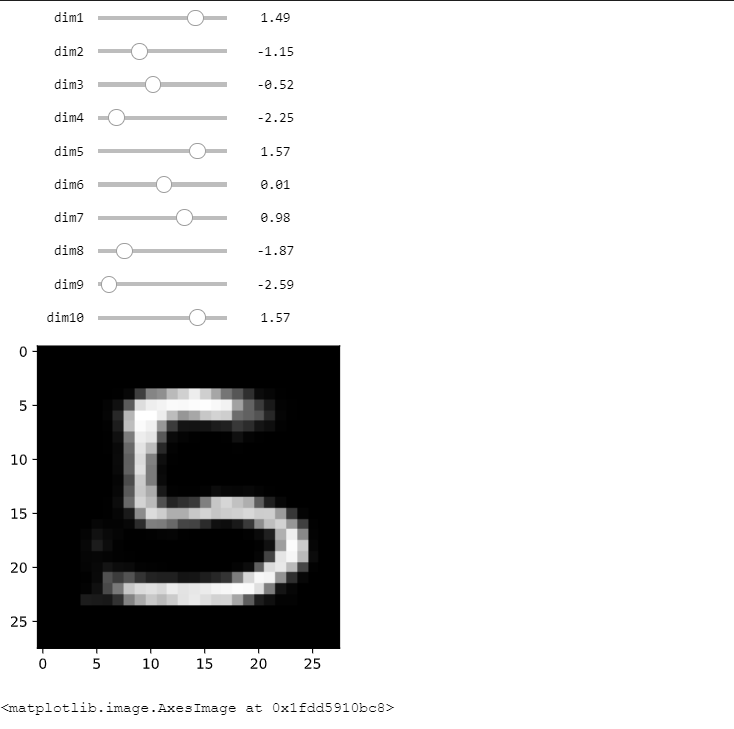

### Plot gaussian distributions of latent variables for images of different digits
#### NOTE: distributions might be slightly different for different images of the same digit
#### NOTE: For example, two images of the digit 0 may have different latent variable distributions

In [15]:
def plot_latent_distributions(to_plot_idx):
    plt.imshow(vae_predictions[to_plot_idx], cmap='gray')
    plt.show()

    for i in range(latent_dim):
        plt.figure(figsize=(10,10))
        plt.subplot(latent_dim, 1, i + 1)
        x = x = np.arange(-10.0, 10.0, 0.01)
        y = norm.pdf(x, latent_mean[to_plot_idx][i], latend_sigma[to_plot_idx][i])
        plt.plot(x, y)
        plt.title('Latent dimension ' + str(i + 1))
        plt.show()

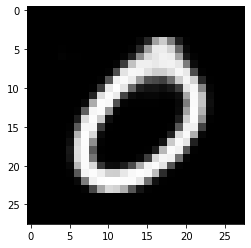

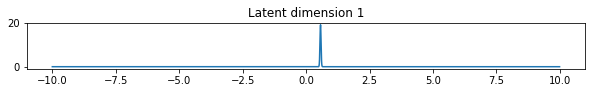

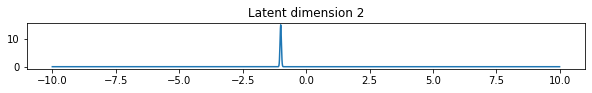

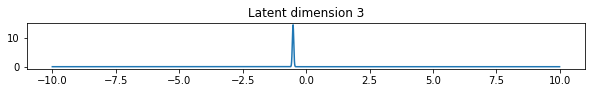

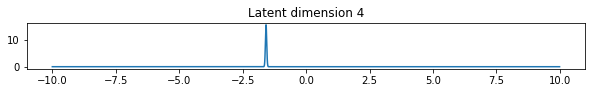

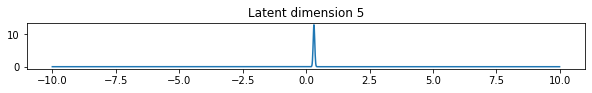

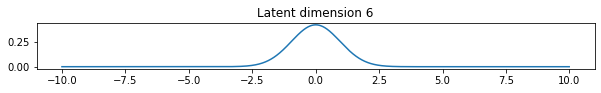

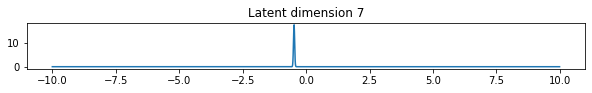

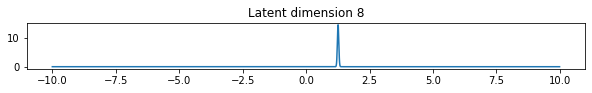

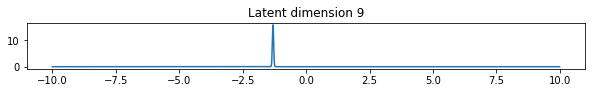

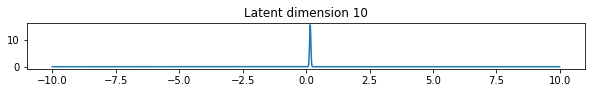

In [16]:
plot_latent_distributions(1)

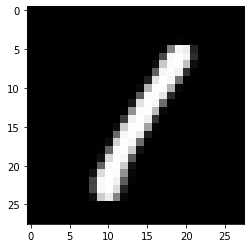

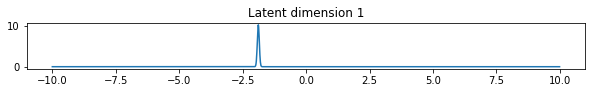

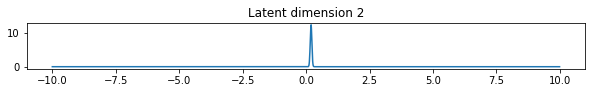

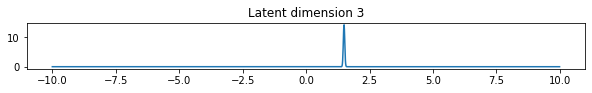

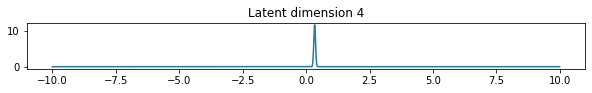

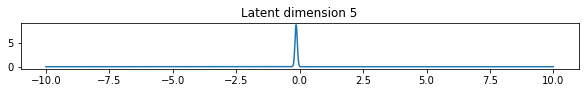

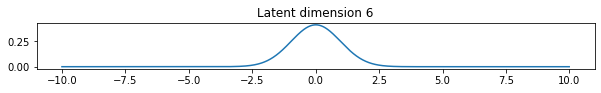

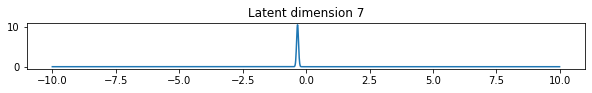

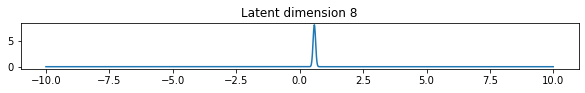

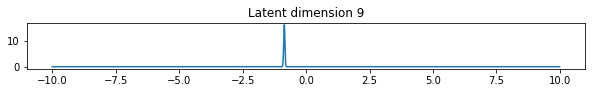

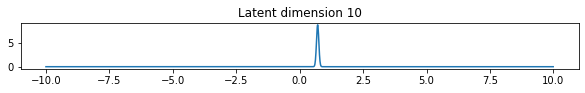

In [17]:
plot_latent_distributions(3)

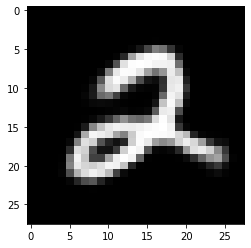

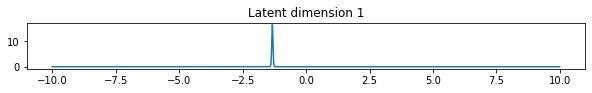

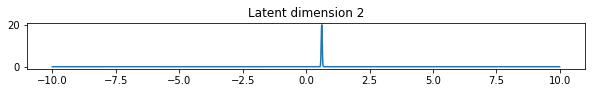

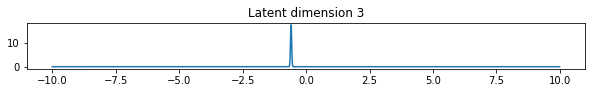

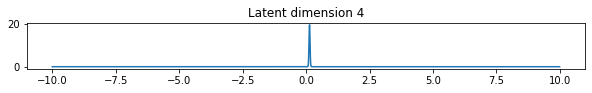

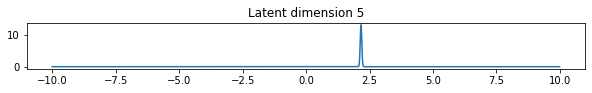

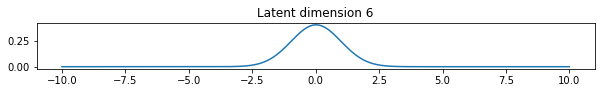

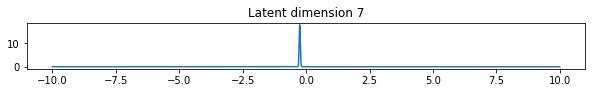

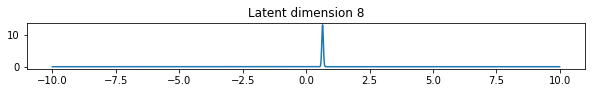

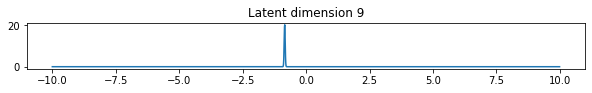

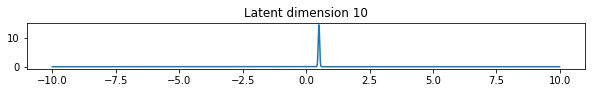

In [18]:
plot_latent_distributions(5)

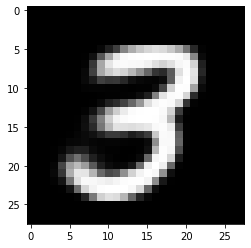

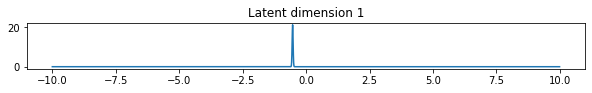

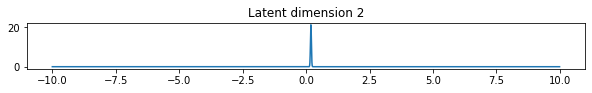

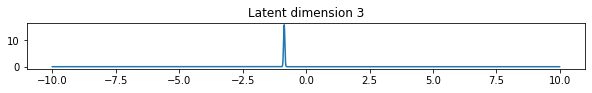

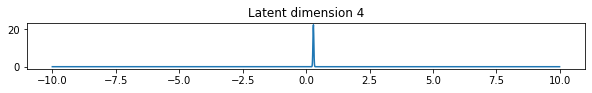

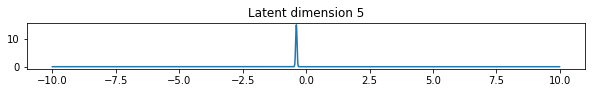

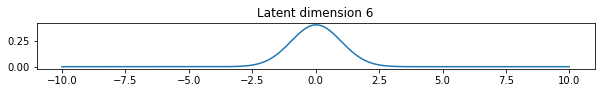

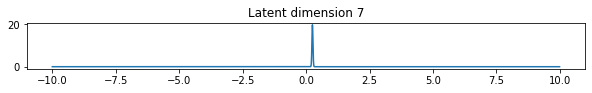

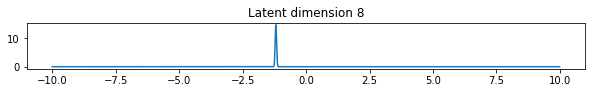

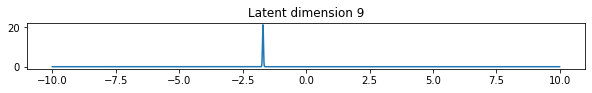

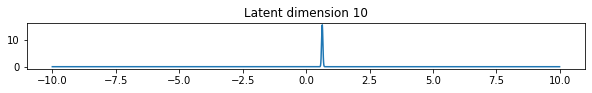

In [19]:
plot_latent_distributions(7)

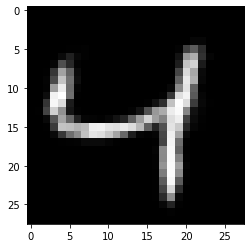

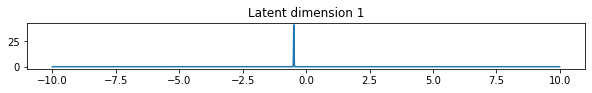

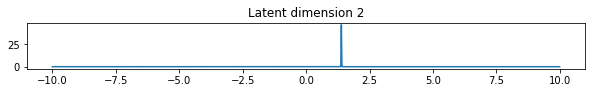

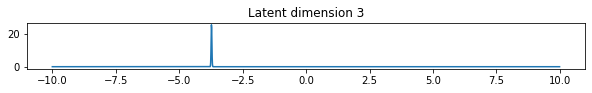

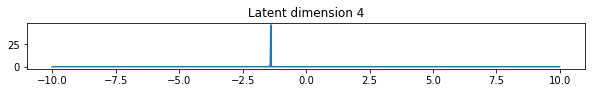

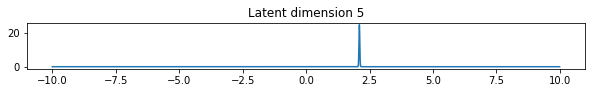

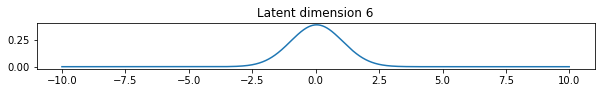

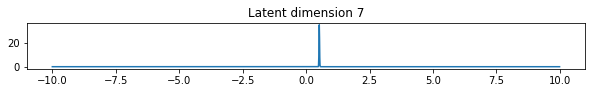

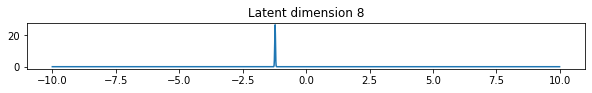

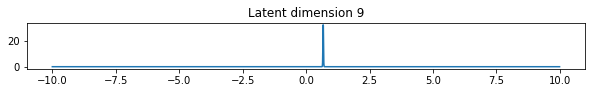

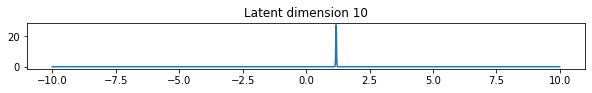

In [20]:
plot_latent_distributions(2)

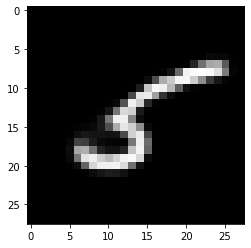

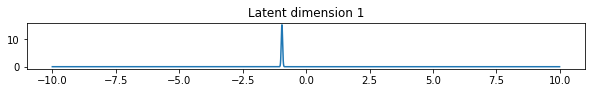

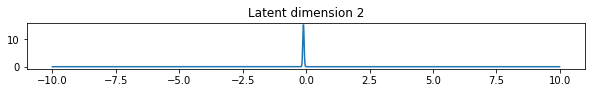

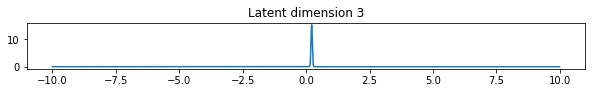

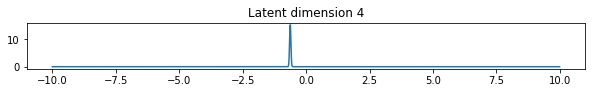

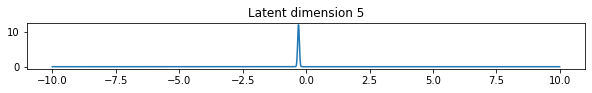

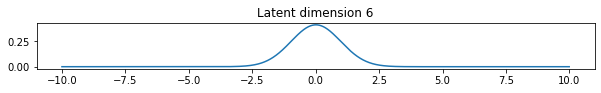

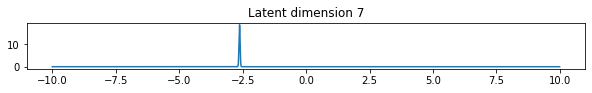

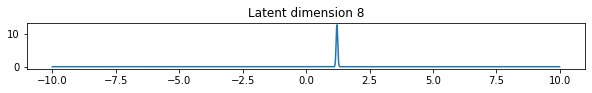

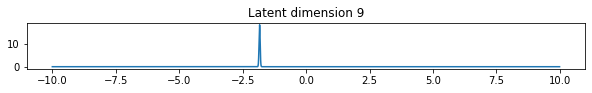

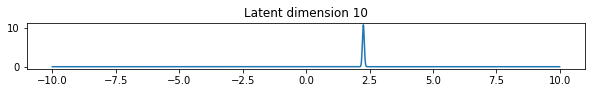

In [21]:
plot_latent_distributions(11)

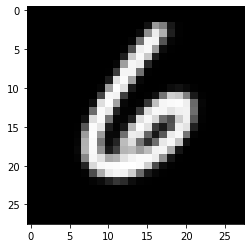

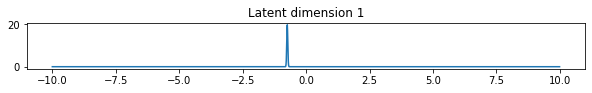

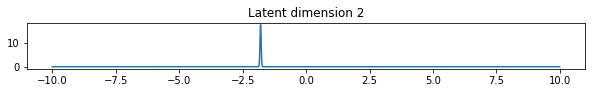

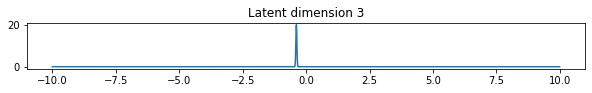

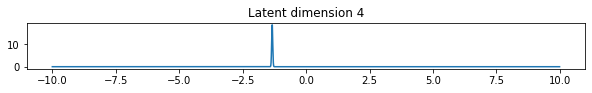

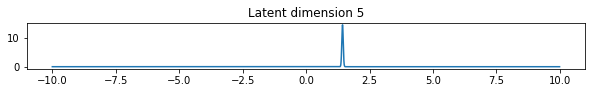

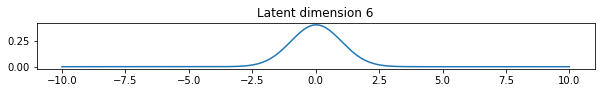

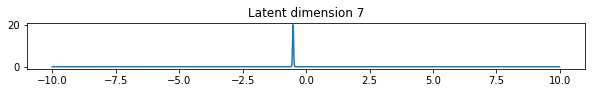

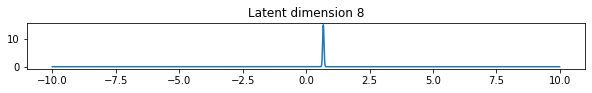

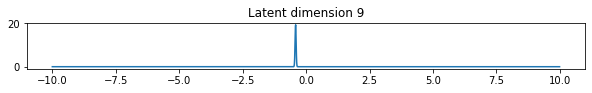

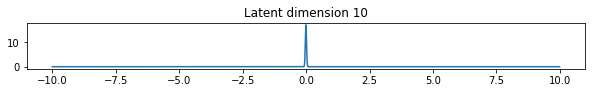

In [22]:
plot_latent_distributions(13)

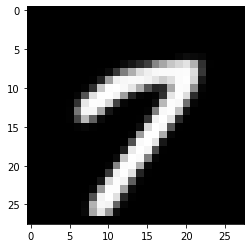

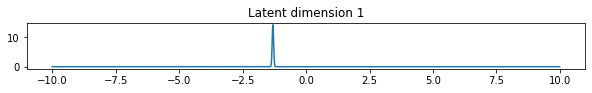

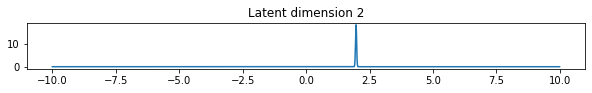

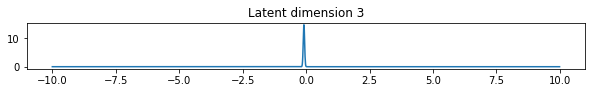

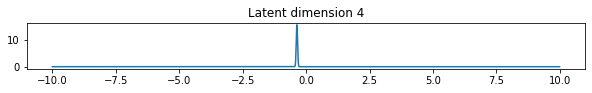

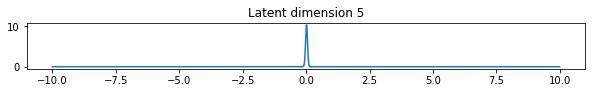

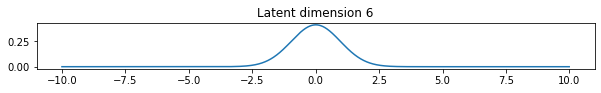

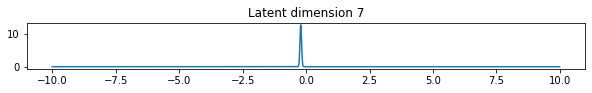

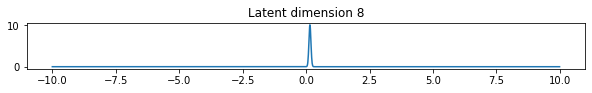

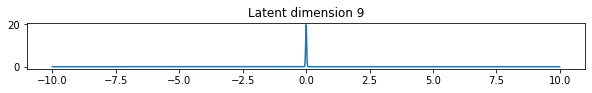

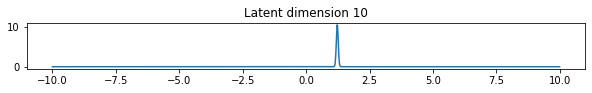

In [23]:
plot_latent_distributions(15)

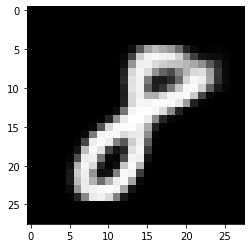

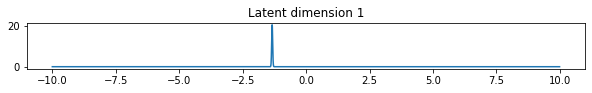

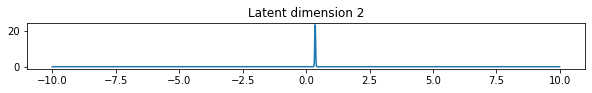

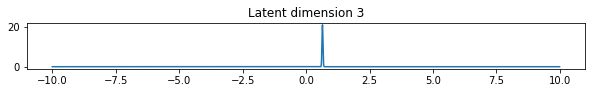

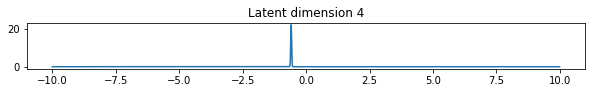

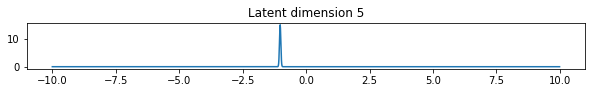

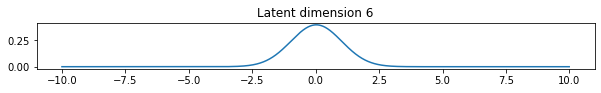

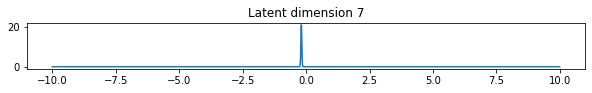

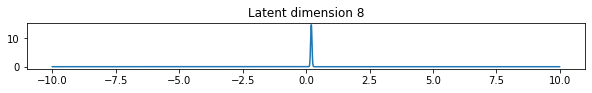

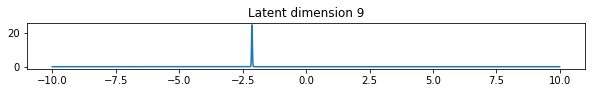

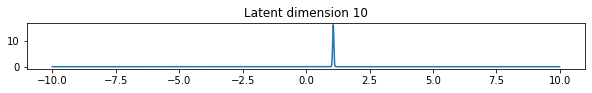

In [24]:
plot_latent_distributions(31)

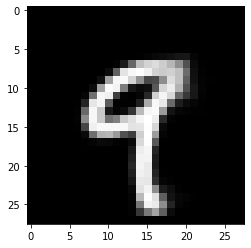

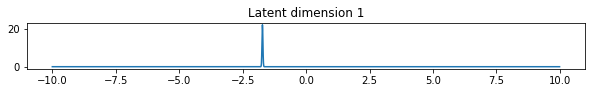

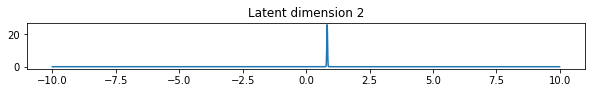

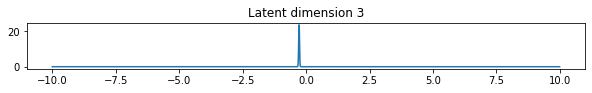

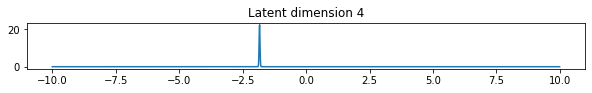

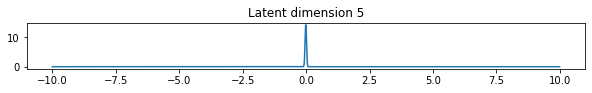

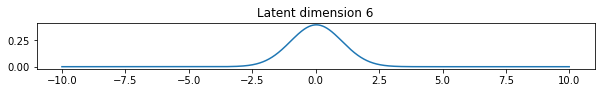

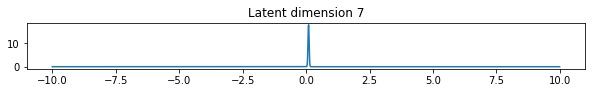

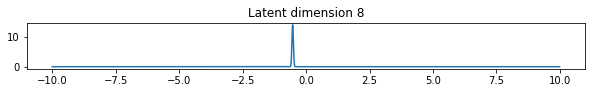

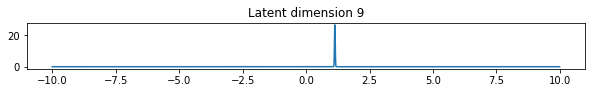

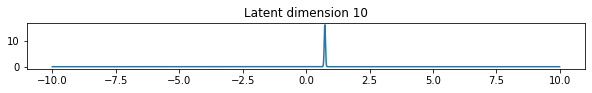

In [25]:
plot_latent_distributions(4)

In [26]:
encoder.save("encoder")
decoder.save("decoder")
vae.save("vae")